In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_table(
    "C:/Users/macka/Google Drive/Level-4-Project/data/raw/Dataset_97.dat",
    sep="\n",
    header=None)

In [4]:
def convert_to_complex(complex_string):
    return complex(complex_string[0].replace('i', 'j'))

In [5]:
center_frequency = float(df.iloc[0])
sweep_time = float(df.iloc[1])/1000  # convert to seconds
number_of_time_samples = float(df.iloc[2])
bandwidth = float(df.iloc[3])
sampling_frequency = number_of_time_samples/sweep_time
record_length = 60
number_of_chirps = record_length/sweep_time
data = df.iloc[4:]
data = data.apply(convert_to_complex, axis=1)
data = data.values

In [6]:
data_time = np.reshape(data, (int(number_of_time_samples), int(number_of_chirps)))
print(data)

[2045.+2060.j 2020.+2082.j 2038.+2033.j ... 2026.+2048.j 2030.+2022.j
 2050.+2036.j]


In [7]:
win = np.ones((int(number_of_time_samples), data_time.shape[1]))
print(win.shape)

(128, 60000)


In [8]:
print(data_time.shape, win.shape)

(128, 60000) (128, 60000)


In [9]:
test = data_time * win
print(test.shape)

(128, 60000)


In [10]:
tmp = np.fft.fft(test)

In [14]:
print(tmp.shape)

(128, 60000)


In [13]:
print(tmp)

[[ 1.22590840e+08+1.23041124e+08j  6.56788955e+02+1.19851769e+03j
   6.14697811e+02-3.92389818e+01j ... -1.21085594e+03+1.23730485e+03j
   2.34203355e+01+1.63289393e+03j  4.72906823e+02-1.44505885e+03j]
 [ 1.22589212e+08+1.23044295e+08j -3.83607202e+02-3.74986715e+03j
  -3.51943663e+03+1.51621968e+03j ... -2.39445581e+03+1.53152490e+03j
  -3.68122723e+02-1.13781211e+03j -1.94455218e+03+1.68015244e+02j]
 [ 1.22588214e+08+1.23039001e+08j -6.59278826e+02-3.14566512e+03j
  -2.97043167e+03-1.60025049e+02j ...  4.69886437e+02-9.16159351e+02j
   7.88450810e+01-1.05365553e+03j  5.66411531e+02-1.27356496e+03j]
 ...
 [ 1.22589104e+08+1.23034012e+08j -3.66063154e+02+2.10992275e+03j
  -1.34397149e+03-1.91029858e+03j ... -2.44582841e+03+7.46704942e+02j
  -1.22474142e+03-1.87174149e+03j  1.03122383e+03-6.14689895e+03j]
 [ 1.22587131e+08+1.23033531e+08j -6.41712035e+02-1.78074853e+03j
   3.94301490e+02-4.09918879e+02j ... -1.76596770e+03+1.62465362e+03j
  -2.28084291e+03-1.17708679e+03j -2.29959414e+

In [11]:
fftshifted = np.fft.fftshift(tmp, 0)

In [12]:
print(fftshifted.shape)

(128, 60000)


In [15]:
data_range = fftshifted[int(number_of_time_samples/2):int(number_of_time_samples), :]
print(data_range.shape)

(64, 60000)


In [16]:
def nearest_odd_number(x):
    if(np.floor(x) % 2 == 0):
        return int(np.floor(x) + 1)
    else:
        return int(np.floor(x))

In [18]:
# IIR Notch filter
x = data_range.shape[1]
ns = nearest_odd_number(x) - 1
print(x, ns)

60000 60000


In [19]:
data_range_MTI = np.zeros((data_range.shape[0], ns))
print(data_range.shape)

(64, 60000)


In [20]:
from scipy.signal import butter, freqz, lfilter

In [21]:
(b, a) = butter(4, 0.01, btype="high")

In [22]:
(f1, h) = freqz(b, a, ns)

In [23]:
print(f1, h)

[0.00000000e+00 5.23598776e-05 1.04719755e-04 ... 3.14143557e+00
 3.14148793e+00 3.14154029e+00] [-1.18712144e-10+0.00000000e+00j -4.74844288e-10+2.01816381e-12j
 -7.12246027e-10+6.18486026e-12j ...  1.00000000e+00+3.22408008e-06j
  1.00000000e+00+2.14938672e-06j  1.00000000e+00+1.07469336e-06j]


In [24]:
for i in range(data_range.shape[0]):
    data_range_MTI[i, :ns] = lfilter(b, a, data_range[i, :ns])

C:\Users\macka\Anaconda3\envs\dataScience\lib\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [25]:
freq = np.arange(0, ns-1)
freq = freq * sampling_frequency/(2*ns)
print(freq)
print(ns)

[0.00000000e+00 1.06666667e+00 2.13333333e+00 ... 6.39957333e+04
 6.39968000e+04 6.39978667e+04]
60000


In [26]:
range_axis = (freq * 3e8*sweep_time)/(2*bandwidth)
print(range_axis)

[0.00000e+00 4.00000e-04 8.00000e-04 ... 2.39984e+01 2.39988e+01
 2.39992e+01]


In [27]:
data_range_MTI = data_range_MTI[1:, :]
data_range = data_range[1:, :]
print(data_range.shape, data_range_MTI.shape)

(63, 60000) (63, 60000)


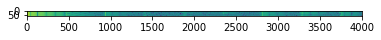

In [29]:
plt.imshow(20 * np.log10(abs(data_range_MTI[:, :4000])))

In [ ]:
# POTENTIALLY ADD WIFI CLEANING